# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

from sklearn import metrics

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', nrows=50000) 
# Limit the numer of row, I broke python several times! I tried to split the dataset in several ranges :/
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

### Cleaning, cleaning and cleaning...

In [3]:
# Let's take a look of this data...
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
# Get the dimensions of the dataset
num_rows = azdias.shape[0]
num_columns = azdias.shape[1]

print(f"The dataset has {num_rows} rows and {num_columns} columns.")

The dataset has 891221 rows and 366 columns.


This dataset is huge!

In [5]:
# See? Huge! So, in order to gain time, we are using 50000 obs
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


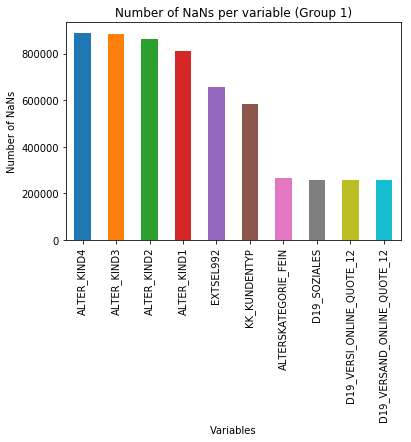

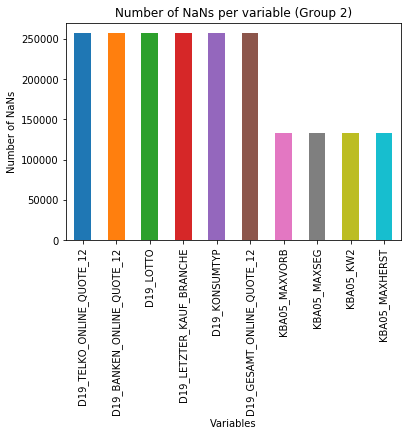

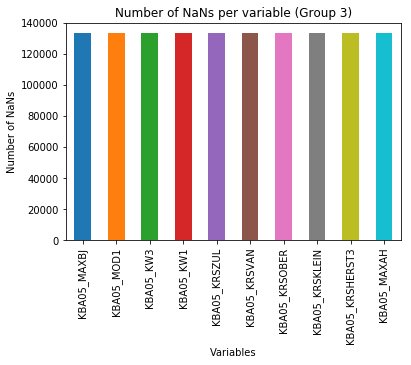

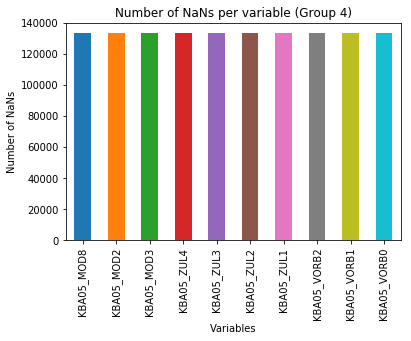

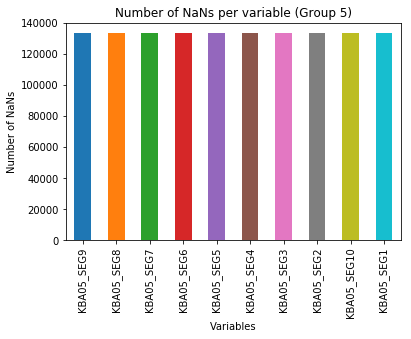

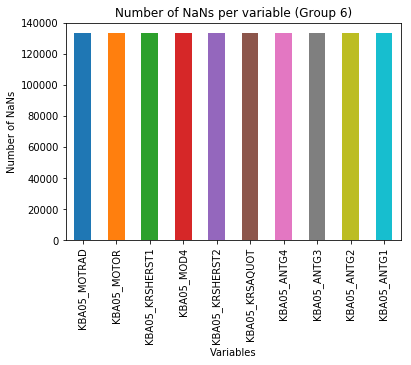

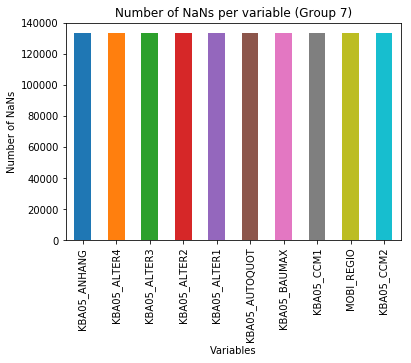

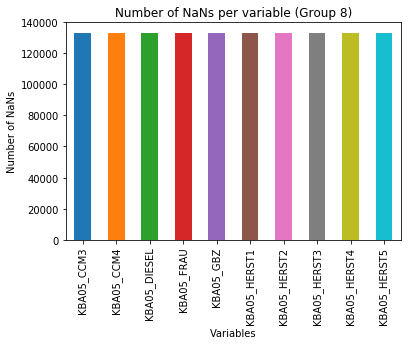

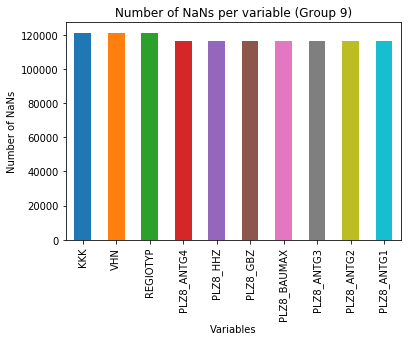

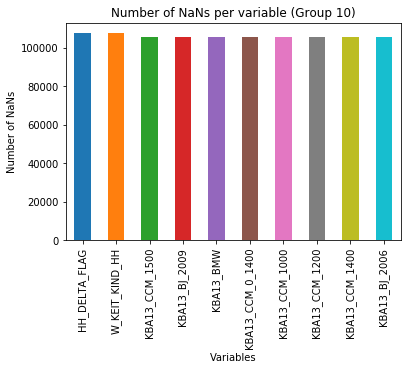

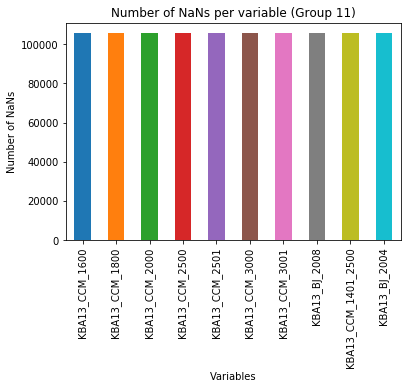

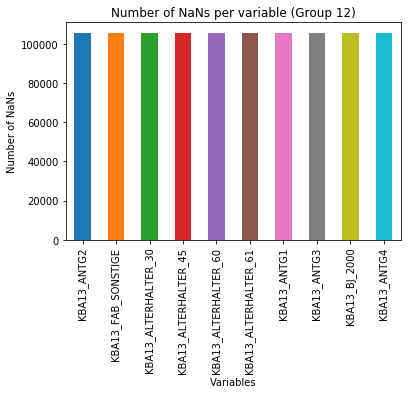

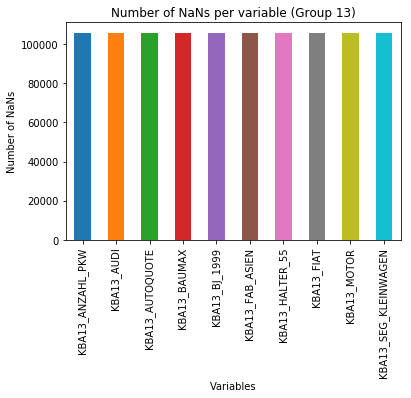

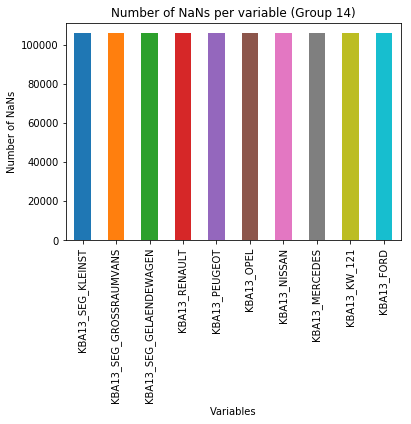

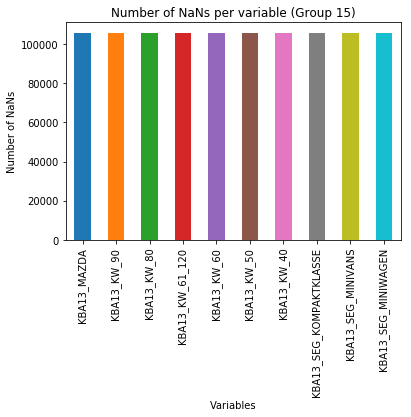

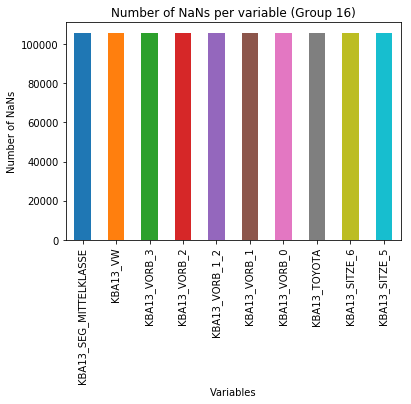

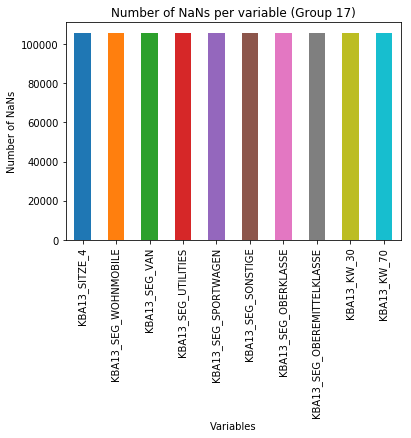

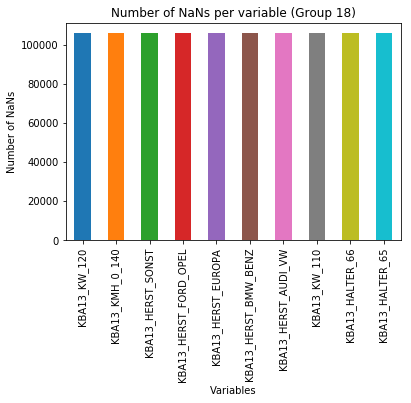

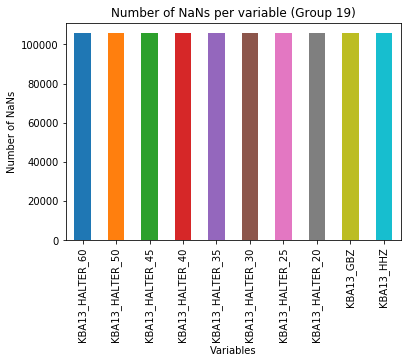

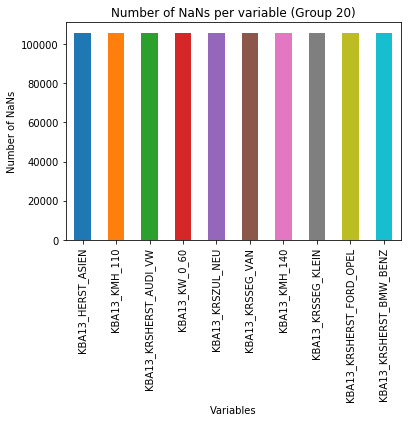

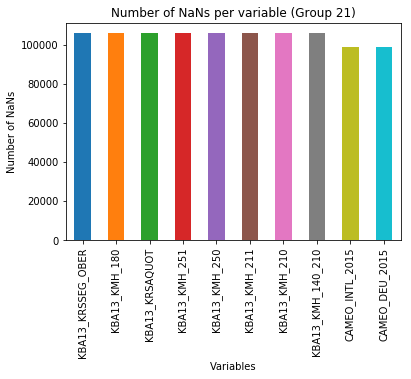

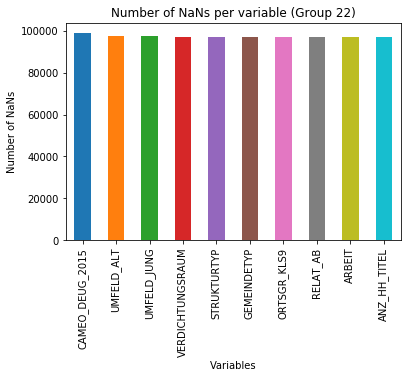

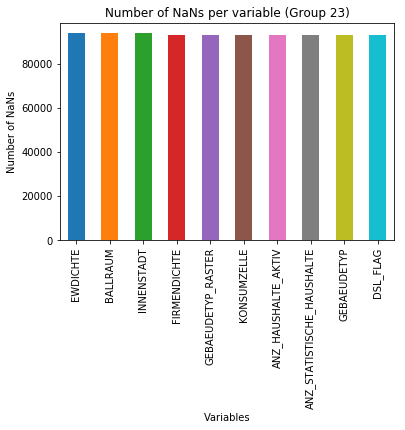

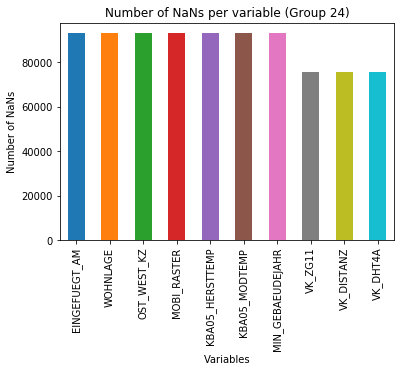

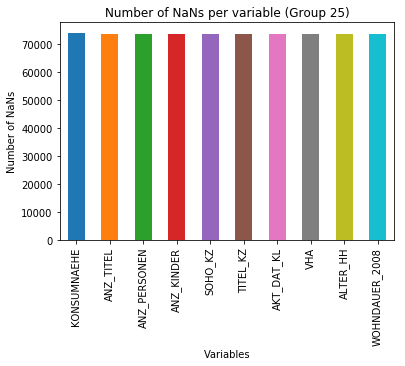

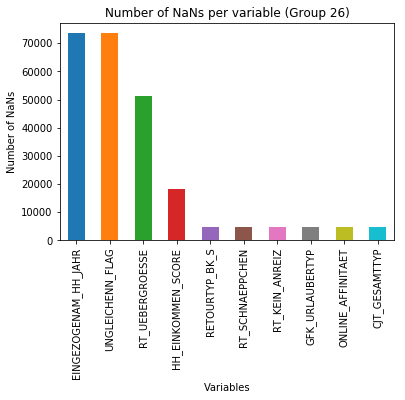

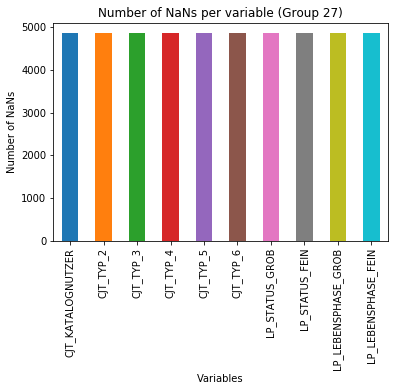

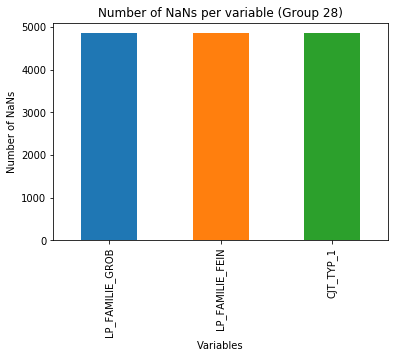

In [6]:
# Let's take a look of NaNs...

# Count the NaNs per variable
nan_counts = azdias.isnull().sum()

# Filter the variables with NaNs
nan_counts = nan_counts[nan_counts > 0]

# Sort the variables by the number of NaNs in descending order
nan_counts = nan_counts.sort_values(ascending=False)

# Split the variables into groups of 10
variable_groups = [nan_counts[i:i+10] for i in range(0, len(nan_counts), 10)]

# Create separate plots for each variable group
for i, group in enumerate(variable_groups):
    if not group.empty:
        group.plot(kind='bar')
        plt.xlabel('Variables')
        plt.ylabel('Number of NaNs')
        plt.title(f'Number of NaNs per variable (Group {i+1})')
        plt.show()

### The NaNs chapter

In [4]:
# Count the number of variables with NaNs
num_variables_with_nans = azdias.isnull().any().sum()

print(f"The dataset contains {num_variables_with_nans} variables with at least one NaN.")

The dataset contains 273 variables with at least one NaN.


In [8]:
# Get the top 10 variables with NaNs
top_10_variables = nan_counts.head(10)

# Calculate the percentage of NaNs for each variable
total_observations = azdias.shape[0]
nan_percentage = (top_10_variables / total_observations) * 100

# Create a table with the results
table = pd.DataFrame({'Variable': top_10_variables.index,
                      'NaN Count': top_10_variables,
                      'NaN Percentage': nan_percentage})

# Display the table
print(table)

                                                Variable  NaN Count  \
ALTER_KIND4                                  ALTER_KIND4     890016   
ALTER_KIND3                                  ALTER_KIND3     885051   
ALTER_KIND2                                  ALTER_KIND2     861722   
ALTER_KIND1                                  ALTER_KIND1     810163   
EXTSEL992                                      EXTSEL992     654153   
KK_KUNDENTYP                                KK_KUNDENTYP     584612   
ALTERSKATEGORIE_FEIN                ALTERSKATEGORIE_FEIN     262947   
D19_SOZIALES                                D19_SOZIALES     257113   
D19_VERSI_ONLINE_QUOTE_12      D19_VERSI_ONLINE_QUOTE_12     257113   
D19_VERSAND_ONLINE_QUOTE_12  D19_VERSAND_ONLINE_QUOTE_12     257113   

                             NaN Percentage  
ALTER_KIND4                       99.864792  
ALTER_KIND3                       99.307691  
ALTER_KIND2                       96.690047  
ALTER_KIND1                       

WOW! As we have a large dataset, we can consider dropping columns with NaNs above 30% of the total, and drop non-informative columns

### Pre-process chapter
Disclaimer: We use only 50000 obs from azdias, since calculations can be sometime very expensive (kernel struggle everytime)
Here we explore The DIAS Attributes - Values 2017.xlsx that has the following columns: 1) Attribute, 2) Description, 3) Value and 4) Meaning. We want to compare this dataset against azdias and costumers dataset in order to finde additional (valuable) information

In [3]:
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', nrows=50000) 

In [5]:
dias_attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)
dias_attributes.head()

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,NaN,NaN,0,no classification possible
NaN,NaN,NaN,1,passive elderly
NaN,NaN,NaN,2,cultural elderly
NaN,NaN,NaN,3,experience-driven elderly


In [6]:
dias_attributes = dias_attributes[dias_attributes['Attribute'].notnull()]

In [7]:
num_rows_az_at = dias_attributes.shape[0]
num_columns_az_at = dias_attributes.shape[1]
print(f"The dias_atributes dataset has {num_rows_az_at} rows and {num_columns_az_at} columns.")

dias_attributes.head()

The dias_atributes dataset has 314 rows and 4 columns.


,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
NaN,ALTER_HH,main age within the household,0,unknown / no main age detectable
NaN,ANREDE_KZ,gender,"-1, 0",unknown
NaN,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)


In [10]:
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [11]:
# Columns in adzias but not in diaz_attrib
azdias_unique_columns = list(set(azdias) - set(dias_attributes['Attribute'].tolist()))
print('Number of unique columns azdias: ', len(azdias_unique_columns), '\n')

Number of unique columns azdias:  94 



In [12]:
# azdias vs customers
customer_unique_columns = set(customers) - set(azdias)
print('Number of unique columns customers: ', len(customer_unique_columns), '\n')

Number of unique columns customers:  3 



In [13]:
# What columns?
customer_unique_columns

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

### Unknown world chapter
We have found that some features have 'unknown', 'unknown / no main age detectable' types. We need to fixed them

In [14]:
# Let's understand the meaning of the first value per attribute
set(dias_attributes['Meaning'].tolist())

{'Event travelers',
 'Universal',
 'Work-Life-Balance',
 'building is located in a 125 x 125m-grid cell (RA1), which is a consumption cell',
 'business cell',
 "doesn't belong to the green avantgarde",
 'highest activity within the last 12 months',
 'low-income earners',
 'mainly 1-2 family homes',
 'no Online-transactions within the last 12 months',
 'no transaction known',
 'no transactions known',
 'none',
 'numeric value',
 'numeric value (typically coded from 1-10)',
 'numeric value (typically coded from 1-3)',
 'single ',
 'single low-income earners of younger age',
 'single low-income- and average earners of younger age ',
 'typical low-income earners',
 'unknown',
 'unknown / no main age detectable',
 'very high mobility',
 'very low',
 'very low car quote'}

In [15]:
# The 'unknown' should be treated as missing values, so here we identify them and apply the same transformation to our azdias datasets 
unknown_world = dias_attributes[dias_attributes['Meaning'].isin(['unknown', 'unknown / no main age detectable'])]
set(unknown_world['Meaning'].tolist())

{'unknown', 'unknown / no main age detectable'}

In [16]:
def attribute_dias(df):
    """"
Converts the columns of the input DataFrame according to description below.

    Args:
        azdias (pd.DataFrame): The input splited azdias DataFrame containing columns to be converted.

    Returns:
        pd.DataFrame: The DataFrame with converted columns.

    Raises:
        None

    Description:
        This function iterates over each column in the given DataFrame, and performs the following actions:
        1. If the column's data type is np.int64, it converts the column to np.float64.
        2. If the column is not present in the 'Attribute' column of the 'unknown_world' DataFrame, it skips to the next column.
        3. It retrieves the 'Value' corresponding to the column from the 'unknown_world' DataFrame.
        4. If the retrieved 'Value' is a string, it converts it to a set of float values.
        5. If the 'Value' is not a string, it converts it to a set containing a single float value.
        6. It uses the 'mask' function to replace values in the column that match the set of unknown values with NaN.    
    """
    for column in df.columns:
        if df[column].dtype == np.int64:
            df[column] = df[column].astype(np.float64)
        if column not in set(unknown_world['Attribute']):
            continue
        
        unknown = unknown_world.loc[unknown_world['Attribute'] == column].Value.item()
        unknown = set(float(x) for x in unknown.split(', ')) if type(unknown) is str else set([float(unknown)])
        df[column] = df[column].mask(df[column].isin(unknown), other=np.nan)
    return df    

In [17]:
azdias = attribute_dias(azdias)

In [18]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225.0,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226.0,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241.0,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


## The NaNs empire strikes back
We have for sure a lot of missing value, as we just added new ones... it is time to be a Jedi an beat them,  column by column, row by row...

In [19]:
# Let's our table of percentage of missing values by column. Can be conservative about dropping columns that have more than 30% of missing data, as we have >800k observations
nan_percentage = azdias.isnull().mean() * 100

In [20]:
nan_percentage.head() # results are close when compare to the whole dataset

LNR             0.000
AGER_TYP       75.706
AKT_DAT_KL      7.468
ALTER_HH       34.486
ALTER_KIND1    90.966
dtype: float64

In [21]:
# Drop columns with missing >20%
drop_columns = nan_percentage[nan_percentage > 20].index
drop_columns

Index(['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KBA05_BAUMAX',
       'KK_KUNDENTYP', 'TITEL_KZ'],
      dtype='object')

In [22]:
azdias.shape

(50000, 366)

Text(0.5,1,'Proportion of missing values in AZDIAS columns')

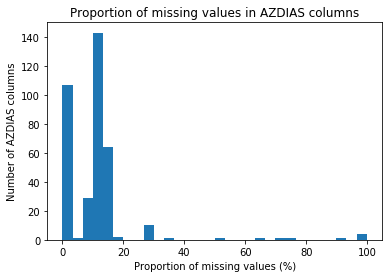

In [23]:
plt.hist(nan_percentage, bins=30);

plt.xlabel('Proportion of missing values (%)')
plt.ylabel('Number of AZDIAS columns')
plt.title('Proportion of missing values in AZDIAS columns')

Alright, most of the columns have less than 20% of missing values, so we drop them and then move on and check out the rows

In [24]:
azdias.drop(labels=drop_columns, axis=1, inplace=True)
azdias.shape

(50000, 346)

In [25]:
percent_nans_row = azdias.isnull().mean(axis=1) * 100
percent_nans_row.head()

0    68.786127
1     0.000000
2     0.000000
3     1.156069
4     0.000000
dtype: float64

Text(0.5,1,'Proportion of missing values in AZDIAS rows')

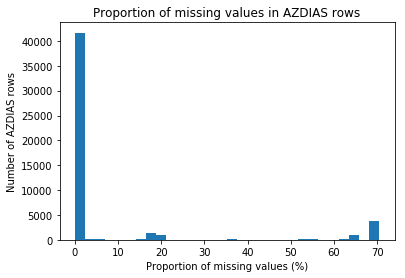

In [26]:
# Repeat the analysis
plt.hist(percent_nans_row, bins=30);

plt.xlabel('Proportion of missing values (%)')
plt.ylabel('Number of AZDIAS rows')
plt.title('Proportion of missing values in AZDIAS rows')

Most of the columns have less than 10% of missing values, sounds like a good threshold.

In [27]:
azdias = azdias[percent_nans_row <= 10]

In [28]:
azdias.shape

(41960, 346)

### Categorical and mixed columns chapter
Here we want to transform categorical values propperly and convert mixed values into numerical values

In [29]:
azdias.columns[azdias.dtypes == "object"]

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'EINGEFUEGT_AM',
       'OST_WEST_KZ'],
      dtype='object')

In [30]:
# We investigate these columns
azdias['CAMEO_DEU_2015'].unique() # We have to take care of 'XX'

array(['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '7A',
       '5D', '9E', '5C', '9B', '1B', '8B', '3D', nan, '4E', '4B', '3C',
       '5A', '7B', '9A', '6E', '6D', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', 'XX'], dtype=object)

In [31]:
azdias['CAMEO_DEUG_2015'].unique() # We have to take care of 'X'

array([8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 7.0, 5.0, 3.0, nan, '3', '7', '2',
       '4', '9', '6', '8', '5', '1', 'X'], dtype=object)

In [32]:
azdias['CAMEO_INTL_2015'].unique() # Multilevel

array([51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 41.0, 34.0,
       55.0, 33.0, 25.0, nan, 23.0, 31.0, 52.0, 45.0, 35.0, 44.0, 32.0,
       '24', '41', '12', '51', '44', '35', '23', '25', '14', '34', '52',
       '55', '31', '32', '22', '15', '13', '43', '45', '33', '54', 'XX'], dtype=object)

In [33]:
azdias['EINGEFUEGT_AM'].unique() #datetime!

array(['1992-02-10 00:00:00', '1992-02-12 00:00:00', '1997-04-21 00:00:00',
       ..., '1997-10-30 00:00:00', '2003-10-23 00:00:00',
       '1997-01-21 00:00:00'], dtype=object)

In [34]:
azdias['OST_WEST_KZ'].unique()

array(['W', 'O'], dtype=object)

In [35]:
# Update 'X' and 'XX' as nan values
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace('X', np.nan)
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].replace('XX', np.nan)

In [36]:
# str to float
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype(float)
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].astype(float)

In [37]:
# To datetime (year)
azdias["EINGEFUEGT_AM"] = pd.to_datetime(azdias["EINGEFUEGT_AM"])
azdias["EINGEFUEGT_AM"] = azdias['EINGEFUEGT_AM'].map(lambda x: x.year)

print('EINGEFUEGT_AM: ', len(azdias["EINGEFUEGT_AM"].unique()), \
      'values, ', azdias["EINGEFUEGT_AM"].unique())

EINGEFUEGT_AM:  14 values,  [1992 1997 1995 1996 2005 2004 2000 1994 1993 2003 1999 2001 1998 2002]


In [38]:
# To binary
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map({'W': 0, 'O': 1})

In [39]:
# Drop multilevel
azdias.drop(['CAMEO_DEU_2015', 'EINGEFUEGT_AM'], axis=1, inplace=True)

When exploring DIAS Attributes - Values 2017.xlsx info, we can see that LP_FAMILIE_FEIN, LP_STATUS_FEIN, LP_LEBENSPHASE_GROB and LP_LEBENSPHASE_FEIN can be dropped since they are multilevel (mixed)

In [40]:
# Drop complex columns
azdias.drop(['LP_FAMILIE_FEIN','LP_STATUS_FEIN','LP_LEBENSPHASE_GROB','LP_LEBENSPHASE_FEIN'], axis=1, inplace=True)

In [41]:
azdias.shape

(41960, 340)

In [42]:
#this is another complex column. However, in this case we can re-encode the column akes unknown values being -1 and 0 and known values ranging from 1 to 15 (It represents two types of donimating movements in the person's youth)
azdias['PRAEGENDE_JUGENDJAHRE'].unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   9.,   6.,   4.,  nan,   5.,
         2.,   1.,  12.,  13.,   7.])

In [43]:
def encode_PRAEGENDE_J(values):
    """
    From attributes:
    Re-encode PRAEGENDE_JUGENDJAHRE:
    0: Mainstream
    1: Avantgarde
    """
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]
    if values in mainstream: 
        return 0
    elif values in avantgarde: 
        return 1
    else:
        return values

In [44]:
azdias['PRAEGENDE_JUGENDJAHRE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: encode_PRAEGENDE_J(x))

In [45]:
azdias['PRAEGENDE_JUGENDJAHRE'].unique()

array([  0.,   1.,  nan])

### Mini chapter: Fill missing values

In [46]:
# We'll keep it simple, and we fill with the mean
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias))
azdias_imputed.shape

(41960, 340)

In [47]:
azdias_imputed.columns = azdias.columns.tolist()

In [48]:
azdias_imputed.columns

Index(['LNR', 'AKT_DAT_KL', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'ANZ_KINDER', 'ANZ_PERSONEN', 'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL',
       'ARBEIT', 'BALLRAUM',
       ...
       'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=340)

In [26]:
# Save this dataset... It's a lot of data right now... The kernel could not handle this.
#azdias_imputed.to_csv('azdias_imputed.csv')

In [27]:
azdias_imputed.shape

(41960, 340)

In [28]:
azdias.shape

(41960, 340)

### Jedi cleaner!

In [49]:
def clean_data(df, dias_attributes, drop_columns, nan_threshold):
    """
    Clean and prerpocess a dataframe
    - convert missing and unknown values to nan values
    - drop columns (features) with high %nan vlaues
    - drop rows with high %nan vlaues
    - re-encode categorical and mixed features
    - drop too highly correlated features
    - impute missing values
    
    INPUT
    - df (DataFrame): the DataFrame to be cleaned and preprocessed
    - dias_attributes (DataFrame): the DataFrame to find unknown values for each feature
    - drop_columns (list): list of features to be droped due to high %nan values
    - nan_threshold (int): threshold to use for dropping rows having high %nan values
    
    OUTPUT
    - df_imputed (DataFrame): a cleaned and preprocessed DataFrame with nan values imputed
    """
    # Missing and unknown values to NaNs
    dias_attributes = dias_attributes[dias_attributes['Attribute'].notnull()]
    unknown_world = dias_attributes[dias_attributes['Meaning'].isin(['unknown', 'unknown / no main age detectable'])]

    for column in df.columns:
        if df[column].dtype == np.int64:
            df[column] = df[column].astype(np.float64)
        if column not in set(unknown_world['Attribute']):
            continue
        
        unknown = unknown_world.loc[unknown_world['Attribute'] == column].Value.item()
        unknown = set(float(x) for x in unknown.split(', ')) if type(unknown) is str else set([float(unknown)])
        df[column] = df[column].mask(df[column].isin(unknown), other=np.nan)
    
    # drop columns with %nan values over a threshold
    df.drop(labels=drop_columns, axis=1, inplace=True)

    # drop rows with %missing values over a threshold
    percent_nans_row = df.isnull().mean(axis=1) * 100
    df = df[percent_nans_row <= nan_threshold]

    # Change EINGEFUEGT_AM to datetime
    df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"])
    df["EINGEFUEGT_AM"] = df['EINGEFUEGT_AM'].map(lambda x: x.year)
    
    # Deal with 'X' and 'XX' to NaNs
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace('XX', np.nan)
    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(float)
    
    # Re-encode to binary
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 0, 'O': 1})
    
    # Drop multi-level
    df.drop(['CAMEO_DEU_2015', 'EINGEFUEGT_AM'], axis=1, inplace=True)

    # Drop complex columns
    df.drop(['LP_FAMILIE_FEIN','LP_STATUS_FEIN','LP_LEBENSPHASE_GROB','LP_LEBENSPHASE_FEIN'], axis=1, inplace=True)    
    
    # re-encode PRAEGENDE_JUGENDJAHRE
    df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: encode_PRAEGENDE_J(x))
       
    # impute missing values
    imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
    df_imputed = pd.DataFrame(imputer.fit_transform(df))    
    
    return df_imputed

In [50]:
# Remember that we found out 3 extra columns?
customers.drop(['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE'], axis=1, inplace=True)

In [51]:
customers.shape

(191652, 366)

In [52]:
# Reload dias_attributes
dias_attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)

In [53]:
# Cross fingers so our Jedi cleaner...
customers_imputed = clean_data(customers, dias_attributes, drop_columns, 10)

In [38]:
#customers_imputed.to_csv('customers_imputed.csv',header=customers_imputed.columns, sep=";")

In [39]:
customers_imputed.shape

(134246, 340)

In [40]:
azdias_imputed.shape

(41960, 340)

In [46]:
list(set(customers_imputed)-set(azdias_imputed))

Cheers! No differences between azdias and customers datasets (imputed ones)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

As we have a large dataset, it would be a good idea to implement PCA for dimension reduction. We need to scale variables first in azdias and customer datasets (imputed)

In [47]:
azdias_imputed = pd.read_csv('azdias_imputed.csv', sep=";")

In [41]:
azdias_imputed.columns

Index(['LNR', 'AKT_DAT_KL', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'ANZ_KINDER', 'ANZ_PERSONEN', 'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL',
       'ARBEIT', 'BALLRAUM',
       ...
       'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=340)

In [3]:
customers_imputed = pd.read_csv('customers_imputed.csv')

In [4]:
scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imputed), columns=azdias_imputed.columns)
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_imputed), columns=customers_imputed.columns)

### PCA chapter

In [5]:
cov_mat = np.cov(azdias_scaled.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

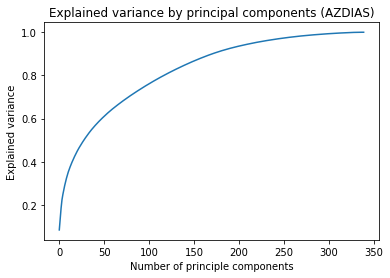

In [6]:
# Plot explained variance on AZDIAS, we'll use 80% as a threshold
pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained variance by principal components (AZDIAS)')
plt.xlabel('Number of principle components')
plt.ylabel('Explained variance')
plt.show()

In [7]:
# Don't forget the same analysis for customers
cov_mat_cus = np.cov(customers_scaled.T)
eig_vals_cus, eig_vecs_cus = np.linalg.eig(cov_mat_cus)

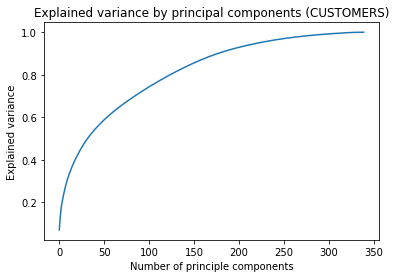

In [8]:
pca = PCA()
customers_pca = pca.fit_transform(customers_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained variance by principal components (CUSTOMERS)')
plt.xlabel('Number of principle components')
plt.ylabel('Explained variance')
plt.show()

In both graphs we can see that around 120-140 components could be appropiate to gather 80% of the variability of our datasets

In [11]:
def reduce_dimension(df, n=130): 
    
    pca = PCA(n_components=n)
    
    df_130 = pca.fit_transform(df)
    df_130 = pd.DataFrame(df_130)
    
    print('Explained data variance by top 130 principal components is equal to ' 
          + str(pca.explained_variance_ratio_.sum())) 
    
    return pca, df_130

In [12]:
pca_azdias, azdias_pca_130 = reduce_dimension(azdias_scaled)

Explained data variance by top 130 principal components is equal to 0.823644032796


In [13]:
# We needed an additional iteration to get close to 80%. Typo: 150 PC
pca_customers, customers_pca_150 = reduce_dimension(customers_scaled, 150)

Explained data variance by top 130 principal components is equal to 0.851237312229


After PCA we reduced the datasets dimensions. Now we move on to the next chapter

### Cluster chapter
k-means!
But, let's save the info, its huge again!

In [16]:
azdias_pca_130.to_pickle('azdias_pca_130.pkl')

In [17]:
customers_pca_150.to_pickle('customers_pca_150.pkl')

In [9]:
azdias_pca_130 = pd.read_pickle('azdias_pca_130.pkl')

In [5]:
customers_pca_150 = pd.read_pickle('customers_pca_150.pkl')

In [8]:
# Defining function to create Elbow Method Visualization
def elbow_method(df):
    '''
    It returns a visualization that shows the sum of squared distances of samples to their closest cluster
    center for each attempt of number of clusters.
    
    Input:
    df: dataframe on which cluster analysis will be performed.
    '''
    # Defining number of clusters attempts:
    n_cluster = range(2, 20, 2)
    
    # Creating inertia list:
    wcss = list()
    
    # Perform K-Means for each attempt and extract its 'inertia' (sum of quared distances to their closest cluster):
    for n in n_cluster:
        kmeans = KMeans(n_clusters = n)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        
    plt.plot(n_cluster, wcss, \
        linestyle= "--",marker = "o", color="red")
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.title('Elbow graph')

    plt.show()

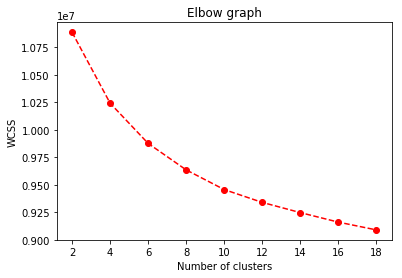

In [9]:
elbow_method(azdias_pca_130)

From the graph, we may be tempted to choose 10 to 14 clusters. Here we just pick 10 as the elbow appears to be there.

In [30]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters)

In [31]:
# azdias clusters:
azdias_clusters = kmeans.fit_predict(azdias_pca_130)
azdias_clusters

array([2, 2, 4, ..., 7, 7, 4], dtype=int32)

In [32]:
# customers clusters:
customers_clusters = kmeans.fit_predict(customers_pca_150)
customers_clusters

array([3, 4, 2, ..., 3, 4, 8], dtype=int32)

In [34]:
# Save them, again ;)
azdias_clusters = pd.DataFrame(azdias_clusters, columns = ['Kmeans_clusters'])
azdias_clusters.to_pickle('azdias_clusters.pkl')

customers_clusters = pd.DataFrame(customers_clusters, columns = ['Kmeans_clusters'])
customers_clusters.to_pickle('customers_clusters.pkl')

#### Evaluating Clusters
After assigning each observation to its respective cluster, the task at hand is to determine which clusters have a higher proportion of clients compared to the overall population. Likewise, it is important to identify clusters that occur more frequently in the general population than in the group of customers.

By doing so, we can gain insights into the distinct combinations of characteristics that make a person more likely to become a client or vice versa.

In [48]:
azdias_clusters['Kmeans_clusters'].value_counts().sort_index()

0    2693
1    2946
2    5846
3    3081
4    5467
5    4446
6    2596
7    4034
8    5328
9    5523
Name: Kmeans_clusters, dtype: int64

In [49]:
customers_clusters['Kmeans_clusters'].value_counts().sort_index()

0     3765
1    10108
2    20305
3    23055
4    17500
5    19191
6     9720
7     5154
8    12603
9    12845
Name: Kmeans_clusters, dtype: int64

In [50]:
cluster_info = pd.DataFrame([])

cluster_info["Population"] = azdias_clusters['Kmeans_clusters'].value_counts().sort_index()
cluster_info["Customer"] = customers_clusters['Kmeans_clusters'].value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

In [51]:
cluster_info

,Cluster,Population,Customer
0,0,2693,3765
1,1,2946,10108
2,2,5846,20305
3,3,3081,23055
4,4,5467,17500
5,5,4446,19191
6,6,2596,9720
7,7,4034,5154
8,8,5328,12603
9,9,5523,12845


In [52]:
cluster_info['%General population'] = (cluster_info['Population'] / (cluster_info['Population'].sum()) * 100).round(2)
cluster_info['%Customer base'] = (cluster_info['Customer'] / (cluster_info['Customer'].sum()) * 100).round(2)

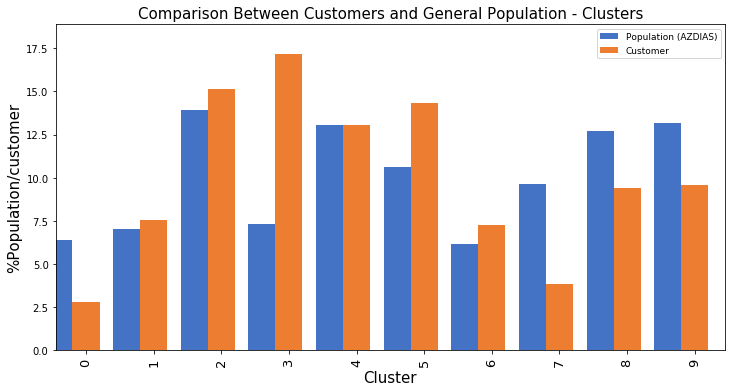

In [57]:
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(111)

colors = ['#4472C4', '#ED7D31'] # Blue and orange colors for the bars

ax = cluster_info['%General population'].plot(x=cluster_info['Cluster'],
width=-0.4, align='edge',
color=colors[0], kind='bar', position=0)
ax = cluster_info['%Customer base'].plot(kind='bar', color=colors[1], width=0.4, align='edge', position=1)

ax.set_xlabel('Cluster', fontsize=15)
ax.set_ylabel('%Population/customer', fontsize=15)

ax.xaxis.set(ticklabels=range(20))
ax.tick_params(axis='x', which='major', labelsize=13)
ax.margins(x=0.05, y=0.1)

plt.legend(('Population (AZDIAS)', 'Customer'), fontsize=9)
plt.title('Comparison Between Customers and General Population - Clusters', fontsize=15)

plt.show()

Here we note that some groups can be underepresented (or not). We can use this info to get a better targetting.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [2]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [3]:
mailout_train.shape

(42962, 367)

In [4]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


We have an additional column: RESPONSE

In [5]:
responses_count = mailout_train['RESPONSE'].value_counts(dropna=False)
perc_no_resp = responses_count.values[0] * 100 / len(mailout_train)
perc_resp = 100 - perc_no_resp
print('{}% of users did not respond and {}% did'.format(np.round(perc_no_resp,2), np.round(perc_resp,2)))

98.76% of users did not respond and 1.24% did


We have to deal with an unbalanced dataset

In [6]:
# Rebalance the dataset
customer_1 = mailout_train[mailout_train['RESPONSE']==1] 
customer_0 = mailout_train[mailout_train['RESPONSE']==0]
customer_1_balanced = resample(customer_1, replace=True, n_samples=42430, random_state=1)
# Merge
mailout_train_balanced = pd.concat([customer_0, customer_1_balanced ])
print(mailout_train_balanced.RESPONSE.value_counts())

1    42430
0    42430
Name: RESPONSE, dtype: int64


In [7]:
mailout_train_balanced['RESPONSE'].isnull().sum()

0

In [8]:
mailout_train_balanced.shape

(84860, 367)

In [9]:
# Now let's clean our data, but first we have to deal with the RESPONSE column (and LNR too)
# RESPONSE out, as labels
labels = mailout_train_balanced['RESPONSE']
# Now, drop it
mailout_train_balanced.drop(labels=['RESPONSE'], axis=1, inplace=True)

In [10]:
labels.sum()/labels.shape[0]

0.5

In [11]:
azdias_imputed = pd.read_csv('azdias_imputed.csv')

In [18]:
keep_columns = azdias_imputed.columns[1:]
keep_columns

Index(['LNR', 'AKT_DAT_KL', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'ANZ_KINDER', 'ANZ_PERSONEN', 'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL',
       'ARBEIT', 'BALLRAUM',
       ...
       'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=340)

In [23]:
# Clean data (Notice that we have to adjust our Jedi cleaner)
def clean_train_data(df, dias_attributes, keep_columns):
    """
    Clean and prerpocess a dataframe
    - convert missing and unknown values to nan values
    - drop columns with high %nan vlaues
    - re-encode categorical and mixed features
    - drop too highly correlated features
    - impute missing values
    
    INPUT
    - df (DataFrame): the DataFrame to be cleaned and preprocessed
    - dias_attributes (DataFrame): the DataFrame to find unknown values for each feature
    - drop_columns (list): list of features to be droped due to high %nan values
    - nan_threshold (int): threshold to use for dropping rows having high %nan values
    
    OUTPUT
    - df_imputed (DataFrame): a cleaned and preprocessed DataFrame with nan values imputed
    """
    # Missing and unknown values to NaNs
    dias_attributes = dias_attributes.reset_index(drop=True)
    dias_attributes = dias_attributes[dias_attributes['Attribute'].notnull()]
    unknown_world = dias_attributes[dias_attributes['Meaning'].isin(['unknown', 'unknown / no main age detectable'])]

    for column in df.columns:
        if df[column].dtype == np.int64:
            df[column] = df[column].astype(np.float64)
        if column not in set(unknown_world['Attribute']):
            continue
        
        unknown = unknown_world.loc[unknown_world['Attribute'] == column].Value.item()
        unknown = set(float(x) for x in unknown.split(', ')) if type(unknown) is str else set([float(unknown)])
        df[column] = df[column].mask(df[column].isin(unknown), other=np.nan)
    
    # drop columns with %nan values over a threshold
    #df.drop(labels=drop_columns, axis=1, inplace=True)

    # Keep columns from cleaned data
    df = df[keep_columns]
    
    # drop rows with %missing values over a threshold
    #percent_nans_row = df.isnull().mean(axis=1) * 100
    #df = df[percent_nans_row <= nan_threshold]

    # Change EINGEFUEGT_AM to datetime
    #df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"])
    #df["EINGEFUEGT_AM"] = df['EINGEFUEGT_AM'].map(lambda x: x.year)
    
    # Deal with 'X' and 'XX' to NaNs
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace('XX', np.nan)
    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(float)
    
    # Re-encode to binary
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 0, 'O': 1})
    
    # Drop multi-level
    #df.drop(['CAMEO_DEU_2015'], axis=1, inplace=True)

    # Drop complex columns
    #df.drop(['LP_FAMILIE_FEIN','LP_STATUS_FEIN','LP_LEBENSPHASE_GROB','LP_LEBENSPHASE_FEIN'], axis=1, inplace=True)    
    
    # re-encode PRAEGENDE_JUGENDJAHRE
    df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: encode_PRAEGENDE_J(x))
       
    # impute missing values
    imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
    df_imputed = pd.DataFrame(imputer.fit_transform(df))    
    
    return df_imputed

In [29]:
# drop rows with %missing values over a threshold
#percent_nans_col_train = mailout_train_balanced.isnull().mean() * 100
#drop_columns_train = percent_nans_col_train[percent_nans_col_train  > 20].index

In [25]:
dias_attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)

In [26]:
dias_attributes.head()

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,NaN,NaN,0,no classification possible
NaN,NaN,NaN,1,passive elderly
NaN,NaN,NaN,2,cultural elderly
NaN,NaN,NaN,3,experience-driven elderly


In [27]:
train_data = clean_train_data(mailout_train_balanced, dias_attributes, keep_columns)

In [28]:
train_data.shape

(84860, 340)

In [29]:
labels.shape

(84860,)

In [30]:
#train_data.to_csv('train_data.csv')
train_data = pd.read_csv('train_data.csv', sep=";")

In [31]:
train_data.shape

(84860, 340)

In [32]:
# Scale columns
scaler = StandardScaler()
train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)

In [33]:
labels.sum()/labels.shape[0] # Balance 

0.5

### Modeling chapter

In [34]:
# Initialize the three models
model_A = LogisticRegression(random_state=13)
model_B = AdaBoostClassifier(random_state=13)
model_C = RandomForestClassifier(random_state=13) # Since it is taking a bit, I'll keep it simple, but we should try several algorithms

In [35]:
# CV
subsets = KFold(n_splits=3, random_state=13)
subsets.get_n_splits(train_data, labels)
print(subsets)

KFold(n_splits=3, random_state=13, shuffle=False)


In [36]:
def train_data_classifier(classifier, param_grid, X=train_data, y=labels):
    """
    Fit a classifier using GridSearchCV, compute ROC AUC metric
    
    INPUT:
    - classifier (classifier): classifier to fit 
    - param_grid (dict): parameters of the classifier used with GridSearchCV
    - X (DataFrame): features of the training dataframe
    - y (DataFrame): labels of the training dataframe
            
    OUTPUT:
    - classifier: fitted classifier
    - AUROC score
    """
        
    grid = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring='roc_auc', cv=3)
    grid.fit(X, y)   
    
    print('AUROC score:', grid.best_score_)
    
    return grid.best_estimator_

In [85]:
#Logistic regression
print(train_data_classifier(model_A, {}))

AUROC score: 0.796663641163
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=13, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [86]:
#ADA boost
print(train_data_classifier(model_B, {}))

AUROC score: 0.774940771894
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=13)


In [94]:
#Random forest
print(train_data_classifier(model_C, {}))

AUROC score: 0.999092623144
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=13, verbose=0, warm_start=False)


### Hyperparametrization: Random Forest

In [37]:
# Create the Random Forest classifier
rfc = RandomForestClassifier(random_state=13)

# Define the parameters to explore in the grid search
rfc_param_grid = {'n_estimators': [10, 20],
                  'max_depth': [None, 5],
                  'min_samples_split': [2, 5],
                  'min_samples_leaf': [1, 2],
                  'random_state': [13]
                 }

rfc_best_estimator = train_data_classifier(rfc, rfc_param_grid)

AUROC score: 0.999858422591


### Time to compete?

In [38]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [39]:
mailout_test.shape

(42833, 366)

In [40]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [41]:
attributes_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)

In [43]:
test_data = clean_train_data(mailout_test, dias_attributes, keep_columns)

In [44]:
# Scale columns
scaler = StandardScaler()
test_data = pd.DataFrame(scaler.fit_transform(test_data), columns=test_data.columns)

In [45]:
test_data.shape

(42833, 340)

In [46]:
test_rfc_pred = rfc_best_estimator.predict_proba(test_data)

In [47]:
test_rfc_pred

array([[ 1.        ,  0.        ],
       [ 0.8       ,  0.2       ],
       [ 1.        ,  0.        ],
       ..., 
       [ 0.9       ,  0.1       ],
       [ 1.        ,  0.        ],
       [ 0.90263158,  0.09736842]])

In [49]:
test_data_LNR = mailout_test['LNR']

In [53]:
kaggle_submission = pd.DataFrame({'LNR':test_data_LNR.astype(np.int32), 'RESPONSE':test_rfc_pred[:, 1]})

kaggle_submission.to_csv('kaggle_submission.csv', index=False)

In [54]:
kaggle_submission.shape

(42833, 2)

In [57]:
kaggle_submission.head()

,LNR,RESPONSE
0,1754,0.0
1,1770,0.2
2,1465,0.0
3,1470,0.0
4,1478,0.0


In [61]:
kaggle_submission['RESPONSE'].mean()

0.037779316342697031

In [62]:
mailout_train['RESPONSE'].mean()

0.012383036171500396